<a href="https://colab.research.google.com/github/preyansh98/Multilabel_Digit_Classification/blob/main/COMP551_Project3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Introduction**

For this project, we will implement a Neural Network to classify multiple labels from a modified MNIST dataset

Project by

*   Preyansh Kaushik - 260790402
*   Shayan Sheikh - 260738247
*   Matthew Kourlas - 260686484


---

# Getting Started

Let's load the data, and visualize what we're working with

In [ ]:
from google.colab import drive
import torch, h5py
import matplotlib.pyplot as plt
import numpy as np
import tensorflow
from tensorflow import keras
import time
import cv2
import math

COLOR = 'ORANGE'
plt.rcParams['text.color'] = COLOR
plt.rcParams['axes.labelcolor'] = COLOR
plt.rcParams['xtick.color'] = COLOR
plt.rcParams['ytick.color'] = COLOR

drive.mount('/content/drive')
path = "/content/drive/MyDrive/MLPROJ3/MNIST_synthetic.h5"

h5_file = h5py.File(path, 'r')
train_dataset = h5_file['train_dataset'].value[:,:,:,0]
test_dataset = h5_file['test_dataset'].value[:,:,:,0]
train_labels = h5_file['train_labels'].value

Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:22: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.


/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


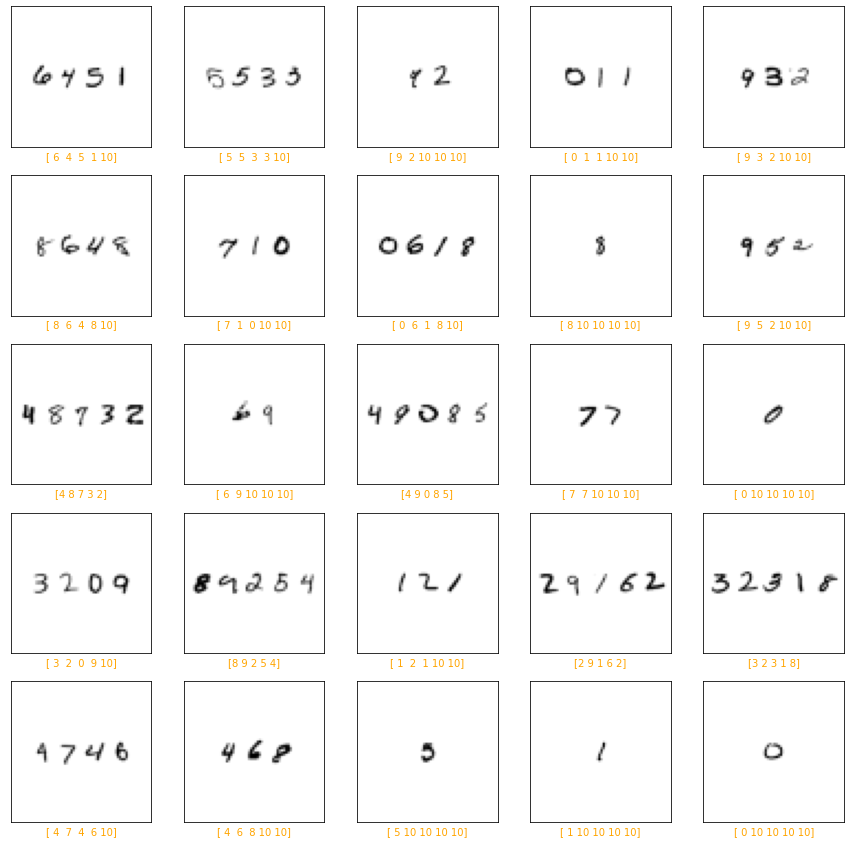

In [ ]:
""" let's just visualize the data we have by plotting a random few"""
plt.figure(figsize=(15,15))
inds = np.random.permutation(len(train_dataset))

for idx, i in enumerate(inds[:25]):
    plt.subplot(5,5,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plot = train_dataset[i]
    plt.imshow(plot, cmap=plt.cm.binary)
    plt.xlabel(train_labels[i])

# Preprocessing

## Extract the image, and create a feature vector from the array of each digit. 
## Then build a single-digit model that predicts and combines them.

### Version 1: Horizontal sweep

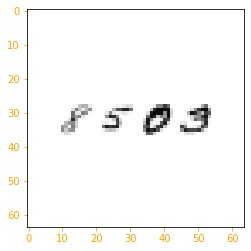

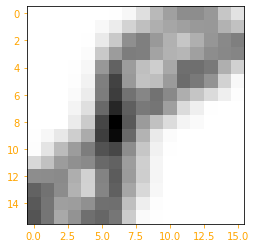

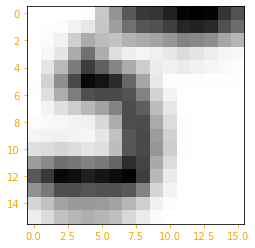

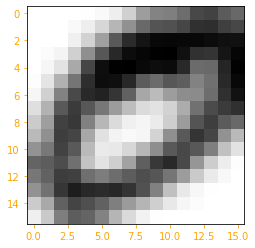

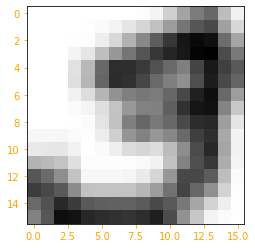

In [ ]:
WHITE_THRESHOLD = 50
SIZE = 16

# returns array of boundaries across rows
def digit_row_segmentation(image, threshold):
  w = image.shape[0]
  boundaries = []
  previous_isBlack = np.max(image[0]) > threshold
  if previous_isBlack:
    boundaries.append(0)
  for i in range(1, w):
    isBlack = np.max(image[i]) > threshold
    if isBlack and not previous_isBlack:
      boundaries.append(i)
    elif not isBlack and previous_isBlack:
      boundaries.append(i-1)
    previous_isBlack = isBlack
  if isBlack:
    boundaries.append(i)
  return boundaries

# returns array of resized digit images
def get_digits(image, threshold, size):
  # vertical segmentation
  w_boundaries = digit_row_segmentation(image.T, threshold)
  
  # get digits
  digits = []
  for i in range(0, len(w_boundaries), 2):
    # horizontal segmentation
    h_boundary = digit_row_segmentation(image[:, w_boundaries[i]:w_boundaries[i+1]+1], threshold)

    # extract digit
    digit = image[h_boundary[0]:h_boundary[1]+1, w_boundaries[i]:w_boundaries[i+1]+1]

    # append resized digit
    digits.append(cv2.resize(digit, (size, size)))

  return digits

train_index = 0
plt.imshow(train_dataset[train_index], cmap=plt.cm.binary)
plt.show()
digits = get_digits(train_dataset[train_index], WHITE_THRESHOLD, SIZE)
for digit in digits:
  plt.imshow(digit, cmap=plt.cm.binary)
  plt.show()

### Version 2: threshold, morphology, contours

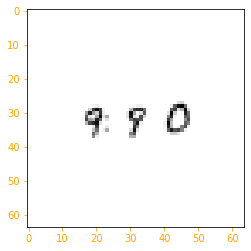

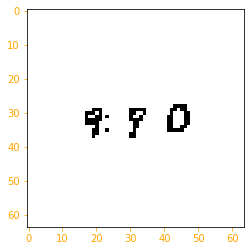

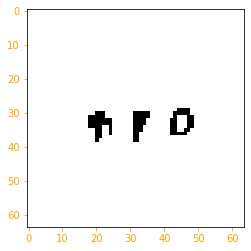

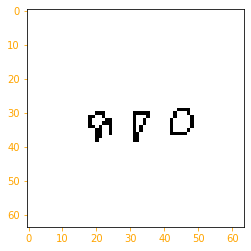

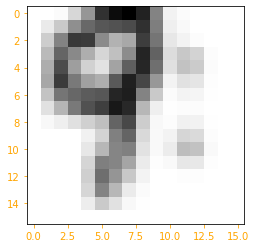

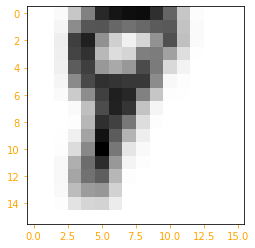

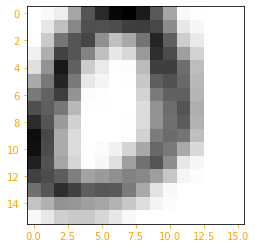

In [ ]:
MIN_DIM = 4
MORPH_KERNEL_SIZE = (4,2)

def get_digits_2(image, threshold, morph_kernel_size, minDim, size, test):
  thresh = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)[1]

  if test:
    plt.imshow(thresh, cmap=plt.cm.binary)
    plt.show()

  thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, np.ones(morph_kernel_size, np.uint8))

  if test:
    plt.imshow(thresh, cmap=plt.cm.binary)
    plt.show()

  contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  digit_rects = []
  digits = []
  for contour in contours:
    rect = cv2.boundingRect(contour)
    if rect[2] >= minDim or rect[3] >= minDim:
      digit_rects.append(rect)
  digit_rects.sort(key=lambda r: r[0])

  if test:
    plt.imshow(cv2.drawContours(np.zeros_like(image), contours, -1, [255,255,255]), cmap=plt.cm.binary)
    plt.show()

  digits = []
  for x,y,w,h in digit_rects:
    maxDim = max(w,h)
    v1 = math.floor((maxDim-w)/2)
    v2 = math.ceil((maxDim-w)/2)
    h1 = math.floor((maxDim-h)/2)
    h2 = math.ceil((maxDim-h)/2)
    digit = cv2.copyMakeBorder(image[y-1:y+h, x-1:x+w], h1, h2, v1, v2, cv2.BORDER_CONSTANT, value=[0,0,0])
    digits.append(cv2.resize(digit, (size, size)))
  return digits

train_index = 2110
plt.imshow(train_dataset[train_index], cmap=plt.cm.binary)
plt.show()
digits = get_digits_2(train_dataset[train_index], WHITE_THRESHOLD, MORPH_KERNEL_SIZE, MIN_DIM, SIZE, True)
for digit in digits:
  plt.imshow(digit, cmap=plt.cm.binary)
  plt.show()

### Version 3: Increase resolution, threshold, dilate/erode (custom morphology), contours

[ 8  5  0  3 10]


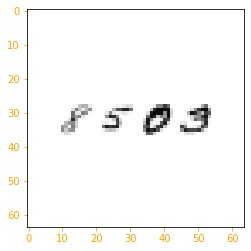

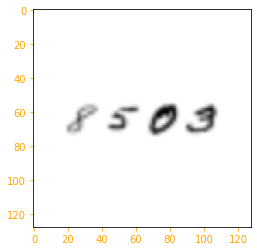

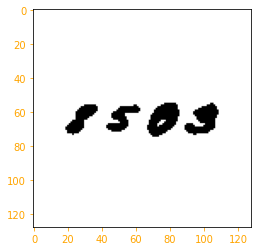

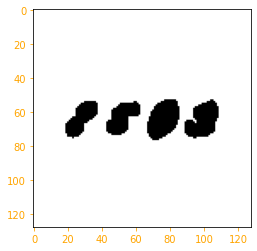

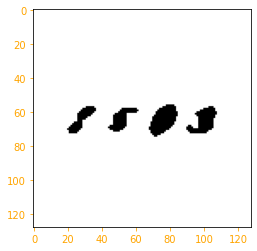

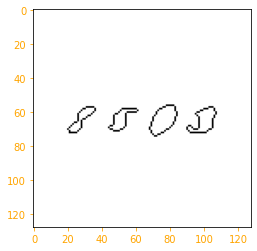

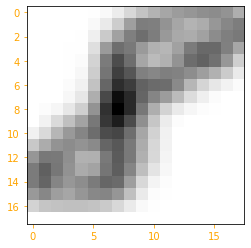

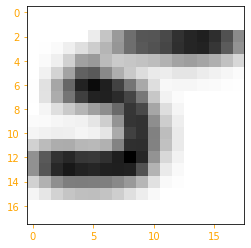

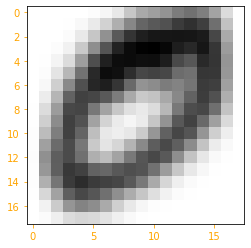

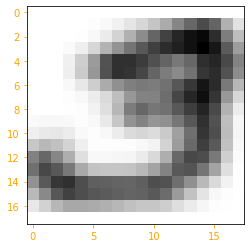

In [ ]:
def get_digits_3(image, size, test):
  # resize for finer detail
  resized = cv2.resize(image, (0,0), fx=2, fy=2).astype(np.uint8)
  # get threshold
  thresh = cv2.threshold(resized, 25, 1, cv2.THRESH_BINARY)[1]
  # dilate vertically to connect detached vertical components
  dilated = cv2.dilate(thresh, np.ones((5,1), np.uint8))
  # erode to detach unwanted connections
  eroded = cv2.erode(dilated, np.ones((6,3), np.uint8))

  if test:
    plt.imshow(resized, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(thresh, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(dilated, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(eroded, cmap=plt.cm.binary)
    plt.show()
  
  contours, _ = cv2.findContours(eroded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  digit_rects = []
  digits = []
  height, width = image.shape
  if test:
    accepted_contours = []
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w >= 10 or h >= 10:
      if test:
        accepted_contours.append(contour)
      digit_rects.append((x,y,w,h))
  digit_rects.sort(key=lambda r: r[0])

  if test:
    plt.imshow(cv2.drawContours(np.zeros_like(resized), accepted_contours, -1, [255,255,255]), cmap=plt.cm.binary)
    plt.show()

  digits = []
  for x,y,w,h in digit_rects:
    maxDim = max(w,h)
    v1 = math.floor((maxDim-w)/2)
    v2 = math.ceil((maxDim-w)/2)
    h1 = math.floor((maxDim-h)/2)
    h2 = math.ceil((maxDim-h)/2)
    digit = cv2.copyMakeBorder(resized[y:y+h, x:x+w], h1, h2, v1, v2, cv2.BORDER_CONSTANT, value=[0,0,0])
    digits.append(cv2.resize(digit, (size, size)))
  return digits

# Problematic images in dataset: 23 262 2410 3709 7491 18127 26042
i = 0
print(train_labels[i])
plt.imshow(train_dataset[i], cmap=plt.cm.binary)
plt.show()
digits = get_digits_3(train_dataset[i], 18, True)
for digit in digits:
  plt.imshow(digit, cmap=plt.cm.binary)
  plt.show()

### Version 4: Version 3 with more refined noise removal

[ 9  7 10 10 10]


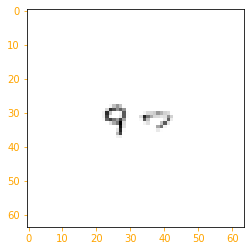

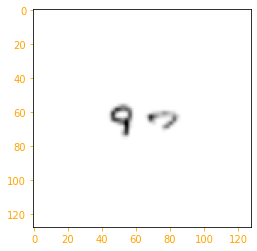

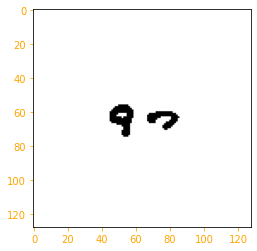

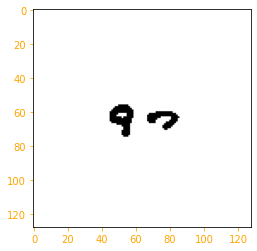

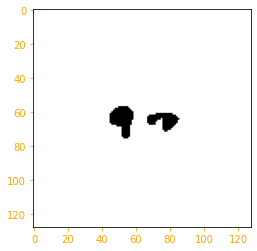

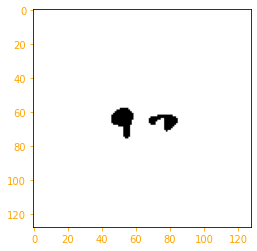

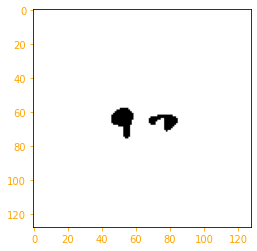

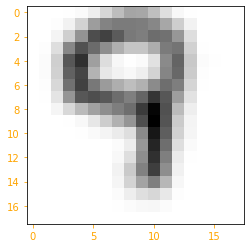

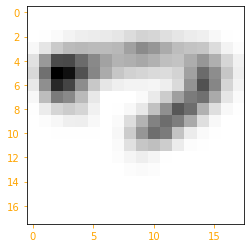

In [ ]:
def removeNoise(image, maxDim, maxArea):
  contours, _ = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  noise_contours = []
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    if w <= maxDim and h <= maxDim or cv2.contourArea(contour) <= maxArea:
      noise_contours.append(contour)
  mask = np.zeros_like(image)
  cv2.drawContours(mask, noise_contours, -1, (255), -1)
  mask = cv2.bitwise_not(mask)
  return cv2.bitwise_and(image, image, mask=mask), mask

def get_digits_4(image, size, test):
  # resize for finer detail
  resized = cv2.resize(image, (0,0), fx=2, fy=2).astype(np.uint8)
  if test:
    plt.imshow(resized, cmap=plt.cm.binary)
    plt.show()
  # get threshold
  thresh = cv2.threshold(resized, 25, 1, cv2.THRESH_BINARY)[1]
  # remove small noise
  smallNoise, mask = removeNoise(thresh, 8, 0)
  resized = cv2.bitwise_and(resized, resized, mask=cv2.erode(mask, np.ones((3,3), np.uint8)))
  # connect components detached vertically
  connected = cv2.morphologyEx(smallNoise, cv2.MORPH_CLOSE, np.ones((10,1), np.uint8))
  # erode to diminish smaller components and break loose connections
  eroded = cv2.erode(connected, np.ones((2,2), np.uint8))
  # remove larger noise
  largeNoise, mask = removeNoise(eroded, 8, 15)
  resized = cv2.bitwise_and(resized, resized, mask=cv2.erode(mask, np.ones((3,3), np.uint8)))

  if test:
    plt.imshow(thresh, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(smallNoise, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(connected, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(eroded, cmap=plt.cm.binary)
    plt.show()
    plt.imshow(largeNoise, cmap=plt.cm.binary)
    plt.show()
  
  contours, _ = cv2.findContours(largeNoise, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  digit_rects = []
  for contour in contours:
    x,y,w,h = cv2.boundingRect(contour)
    digit_rects.append((x-2,y-2,w+4,h+4))
  digit_rects.sort(key=lambda r: r[0])

  digits = []
  for x,y,w,h in digit_rects:
    maxDim = max(w,h)
    v1 = math.floor((maxDim-w)/2)
    v2 = math.ceil((maxDim-w)/2)
    h1 = math.floor((maxDim-h)/2)
    h2 = math.ceil((maxDim-h)/2)
    digit = cv2.copyMakeBorder(resized[y:y+h, x:x+w], h1, h2, v1, v2, cv2.BORDER_CONSTANT, value=[0,0,0])
    digits.append(cv2.resize(digit, (size, size)))
  return digits

i = 45009
print(train_labels[i])
plt.imshow(train_dataset[i], cmap=plt.cm.binary)
plt.show()
digits = get_digits_4(train_dataset[i], 18, True)
for digit in digits:
  plt.imshow(digit, cmap=plt.cm.binary)
  plt.show()

### Version 1-4 Test

2684


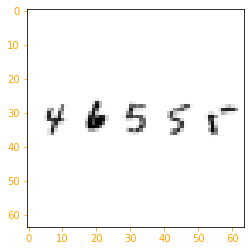

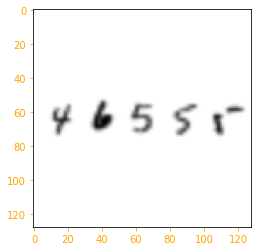

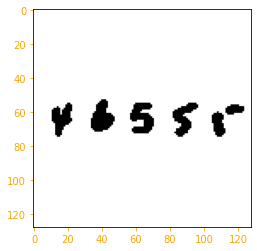

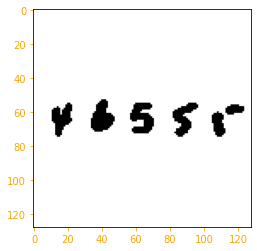

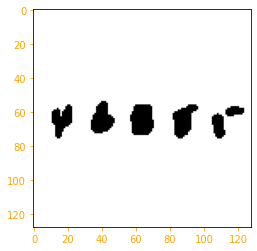

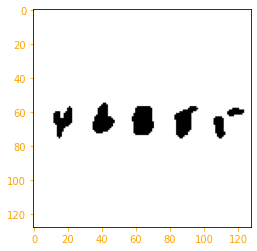

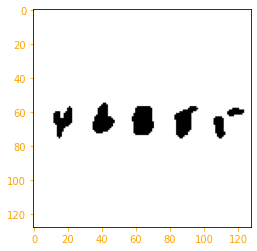

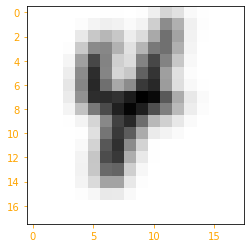

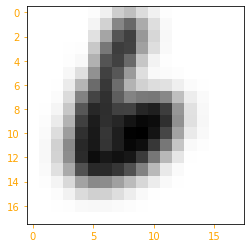

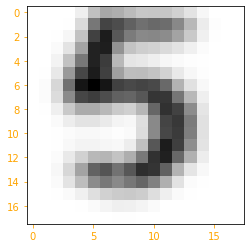

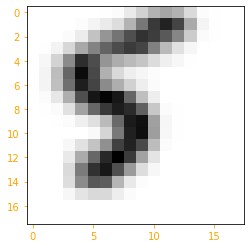

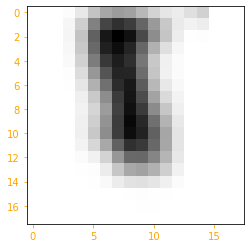

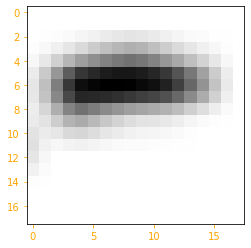

18127


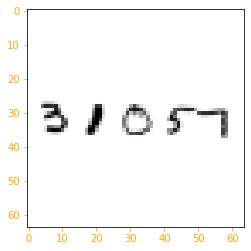

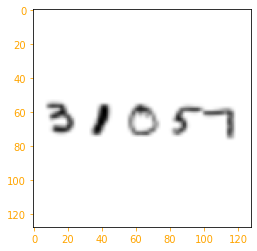

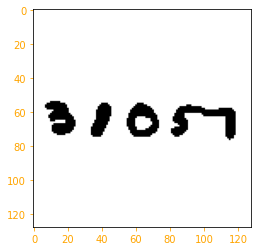

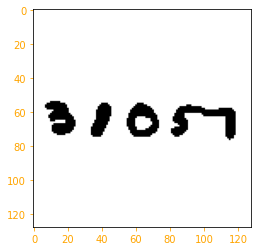

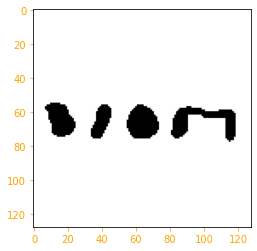

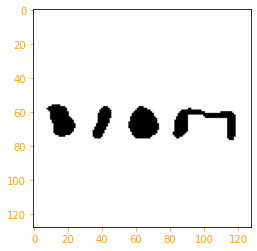

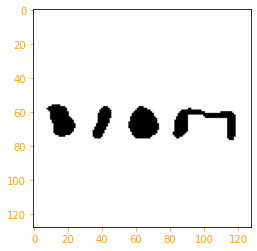

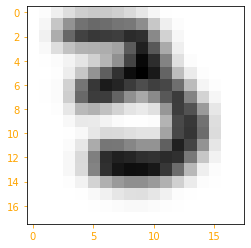

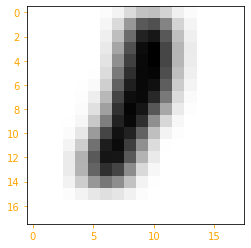

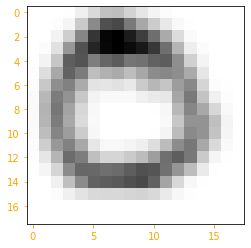

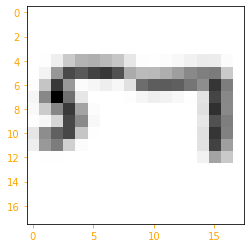

26042


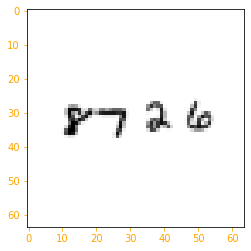

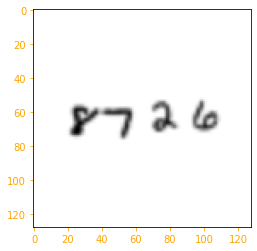

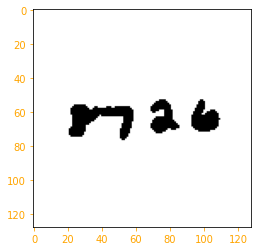

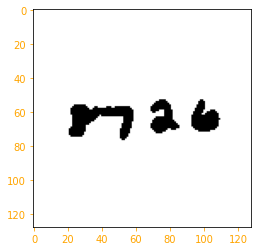

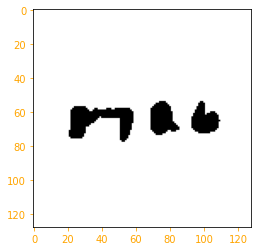

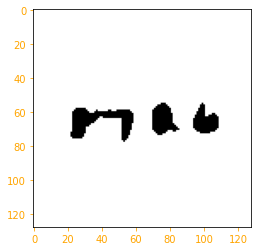

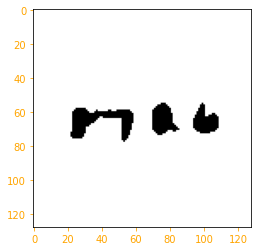

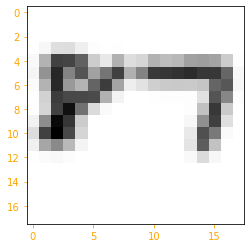

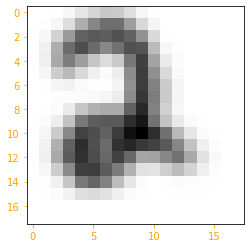

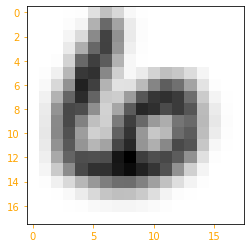

5.357142857142857e-05
3 out of 56000


In [ ]:
percent = False
#def digits_func(i, test): return get_digits(train_dataset[i], WHITE_THRESHOLD, SIZE)
#def digits_func(i, test): return get_digits_2(train_dataset[i], 50, (5,2), 4, SIZE, test)
#def digits_func(i, test): return get_digits_3(train_dataset[i], 18, test)
def digits_func(i, test): return get_digits_4(train_dataset[i], 18, test)

j = 0
for i in range(len(train_dataset)):
  digits = digits_func(i, False)
  if len(digits) != np.count_nonzero(train_labels[i] != 10):
    if not percent:
      print(i)
      plt.imshow(train_dataset[i], cmap=plt.cm.binary)
      plt.show()
      digits = digits = digits_func(i, True)
      for digit in digits:
        plt.imshow(digit, cmap=plt.cm.binary)
        plt.show()
    j += 1

print(j/len(train_dataset))
print("{} out of {}".format(j, len(train_dataset)))

### Version 1.5 (rejected openCV implementation)

Image 18 was not segmented correctly. Segmented digits: 5, Labels: [ 1  4  0  1 10]


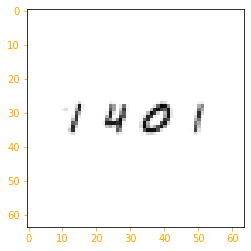

Image 19 was not segmented correctly. Segmented digits: 6, Labels: [8 8 3 6 5]


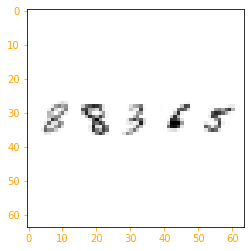

Image 41 was not segmented correctly. Segmented digits: 6, Labels: [0 3 8 5 5]


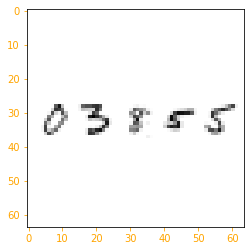

Image 62 was not segmented correctly. Segmented digits: 2, Labels: [ 0 10 10 10 10]


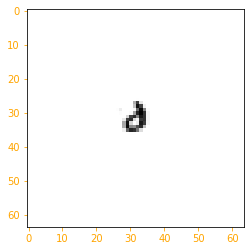

Image 63 was not segmented correctly. Segmented digits: 4, Labels: [ 8  3  9 10 10]


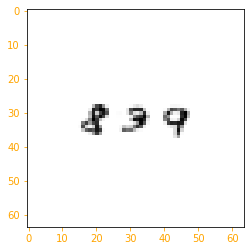

Image 77 was not segmented correctly. Segmented digits: 5, Labels: [ 1  1  3  6 10]


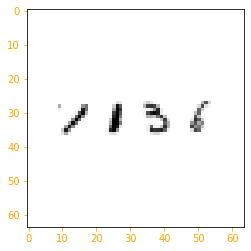

Image 95 was not segmented correctly. Segmented digits: 3, Labels: [ 8  6 10 10 10]


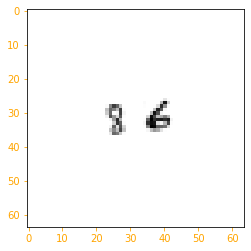

Image 202 was not segmented correctly. Segmented digits: 6, Labels: [3 9 2 8 1]


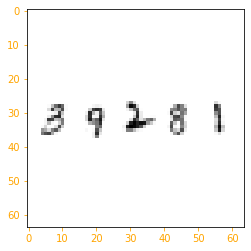

Image 264 was not segmented correctly. Segmented digits: 3, Labels: [ 9  9  5  7 10]


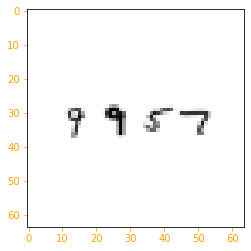

Image 312 was not segmented correctly. Segmented digits: 6, Labels: [2 2 2 2 3]


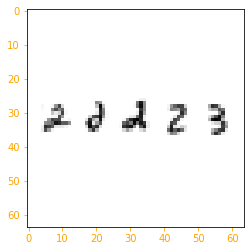

Image 354 was not segmented correctly. Segmented digits: 2, Labels: [ 6 10 10 10 10]


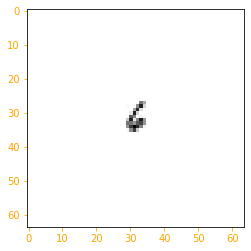

Image 493 was not segmented correctly. Segmented digits: 5, Labels: [ 6  1  1 10 10]


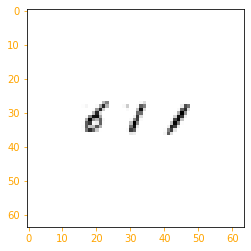

Image 558 was not segmented correctly. Segmented digits: 4, Labels: [ 6  1  6 10 10]


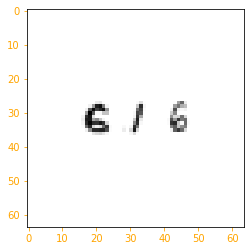

Image 568 was not segmented correctly. Segmented digits: 3, Labels: [ 0  7 10 10 10]


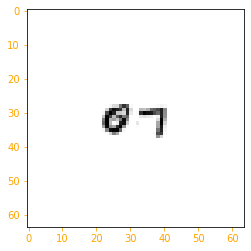

Image 706 was not segmented correctly. Segmented digits: 4, Labels: [4 8 3 2 2]


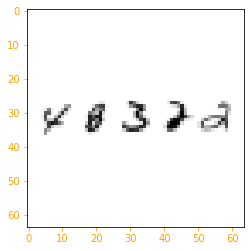

Image 738 was not segmented correctly. Segmented digits: 6, Labels: [2 1 9 7 8]


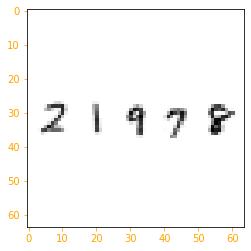

Image 763 was not segmented correctly. Segmented digits: 5, Labels: [ 2  1  6  3 10]


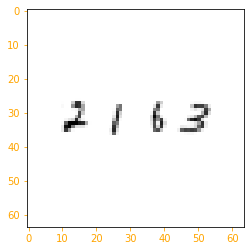

Image 825 was not segmented correctly. Segmented digits: 3, Labels: [ 7  1 10 10 10]


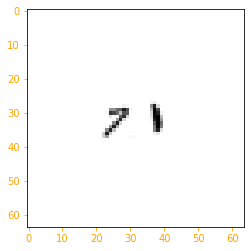

Image 852 was not segmented correctly. Segmented digits: 3, Labels: [ 1  7 10 10 10]


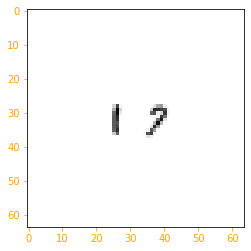

Image 867 was not segmented correctly. Segmented digits: 4, Labels: [ 3  6  3 10 10]


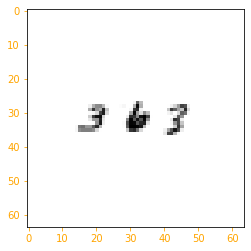

0.026321428571428572


In [ ]:
""" OpenCV way to preprocess and find digits """
""" TODO: find a way to also generate each label for digit, the contours are not foudn left to right """ 

def opencv_get_segmented_digits(image):
  digits = []
  # plt.imshow(image,cmap=plt.cm.binary)
  # plt.show()
  gray = image.copy()
  threshold = gray.copy()
  contours , _ = cv2.findContours(threshold.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  for contour in contours:
    # get bounding rectangle
    x,y,w,h = cv2.boundingRect(contour)
    cv2.rectangle(image, (x,y), (x+w, y+h), color=(0, 255, 0), thickness=2)

    digit = threshold[y:y+h, x:x+w]
    digit = cv2.resize(digit, (18,18))
    
    digits.append(digit)

  # for i in range(len(digits)):
  #   plt.imshow(digits[i], cmap=plt.cm.binary)
  #   plt.show()

  return digits

#opencv_get_segmented_digits(train_dataset[0].copy())  

## let's test opencv the same way as our line sweep

j = 0
for i in range(len(train_dataset)):
  n_digits = len(opencv_get_segmented_digits(train_dataset[i].copy()))
  if n_digits != np.count_nonzero(train_labels[i] != 10):
    if j < 20:
      print("Image {} was not segmented correctly. Segmented digits: {}, Labels: {}".format(i, n_digits, train_labels[i]))
      plt.imshow(train_dataset[i], cmap=plt.cm.binary)
      plt.show()

    j += 1
    
print(j/len(train_dataset))

### Old implementation of version 1

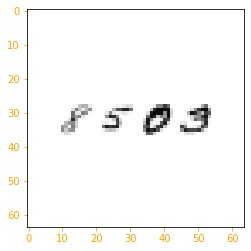

Digit:  8
(18, 18)


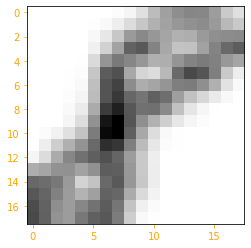

Digit:  5
(18, 18)


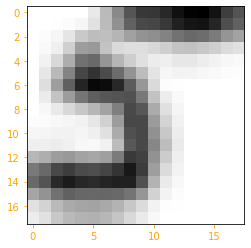

Digit:  0
(18, 18)


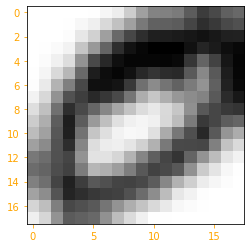

Digit:  3
(18, 18)


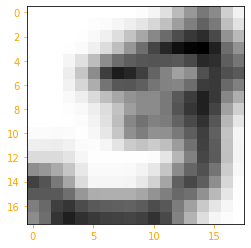

In [ ]:
""" takes in an image and label and returns [image segments] with [segment labels] """

def get_image_segments_and_label(image, multilabel, threshold):
  segments = []
  labels = []

  """ first segment the images """

  # vertical segmentation
  w_boundaries = digit_row_segmentation(image.T, threshold)

  # horizontal segmentation
  h_boundaries = [digit_row_segmentation(image[:, w_boundaries[i]:w_boundaries[i+1]+1], threshold) for i in range(0, len(w_boundaries), 2)]

  for i in range(min(len(h_boundaries),5)):
    segment = image[h_boundaries[i][0]:h_boundaries[i][1]+1, w_boundaries[i*2]:w_boundaries[i*2+1]+1]   

    """ resize image for consistency, we can do this in segmentation instead """
    segment = cv2.resize(segment, (18,18))
    
    """ dilate image to accentuate the pixel features, commenting out as its not increasing accuracy. """
    # kernel = np.ones((2,2), 'uint8')
    # segment = cv2.dilate(segment, kernel)

    segments.append(segment)
    labels.append(multilabel[i])

  return segments, labels

""" define a function for test data that gets segments """
def get_image_segments_test(image, threshold):
  return get_image_segments_and_label(image, [10]*5, threshold)[0]

test_index = 0

segments, labels = get_image_segments_and_label(train_dataset[test_index], train_labels[test_index], WHITE_THRESHOLD)

plt.imshow(train_dataset[test_index], cmap=plt.cm.binary)
plt.show()

for i in range(len(segments)):
  print("Digit: ", labels[i])
  print(segments[i].shape)
  plt.imshow(segments[i], cmap=plt.cm.binary)
  plt.show()

so open cv does 0.02 error, while line sweep does 0.004, we'll just use our own line sweep instead of opencv then.

# Models (Convolutional Neural Network)

In [ ]:
# prepare data for model, and get train-validation split
IMAGE_SIZE = 18

from sklearn.model_selection import KFold
from collections import defaultdict

def segment_data_to_x_y(img_size):
  X = []
  Y = []

  # just keeping a mapping of train dataset indices to a list of indices in X and Y of the segments.
  # i.e. train_dataset [1] (first image) -> has segments at indices [3,4,5] in X.  
  i_to_j_indices = defaultdict(list)

  for i in range(len(train_dataset)):
    #segments, labels = get_image_segments_and_label(train_dataset[i], train_labels[i], WHITE_THRESHOLD)
    segments = get_digits_4(train_dataset[i], img_size, False)
    labels = train_labels[i].tolist()

    # If digit segmentation failed, then the digit-label pairings may be misaligned
    if len(segments) != len(labels) - labels.count(10):
      continue
    
    for j in range(len(segments)):
      X.append(segments[j])
      Y.append(labels[j])
      i_to_j_indices[i].append(len(X)-1)

  return X, Y, i_to_j_indices

""" defining utility function that transforms data to keras format """
def prepare_n_folds(X, Y, n_folds=5):
  kf = KFold(n_folds)

  folds = []

  for train_idx, valid_idx in kf.split(X, Y):
    x_train, x_valid = np.array(X)[train_idx], np.array(X)[valid_idx]
    y_train, y_valid = np.array(Y)[train_idx], np.array(Y)[valid_idx]

    # reshape data for keras api
    x_train = np.asarray(x_train)
    x_valid = np.asarray(x_valid)
    y_train = np.asarray(y_train)
    y_valid = np.asarray(y_valid)
    x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    x_valid = x_valid.reshape(x_valid.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)

    data = ( (x_train, y_train) , (x_valid, y_valid) )
    
    folds.append(data)

  return folds

# store data into runtime
X, Y, i_to_j_indices = segment_data_to_x_y(IMAGE_SIZE)
folds = prepare_n_folds(X,Y)

Now that our data is ready, we will define our ConvNet Model Architecture. 

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, ZeroPadding2D
from sklearn.metrics import accuracy_score
import timeit

IMAGE_SIZE = 18

def convnet():
  model = Sequential()
  model.add(ZeroPadding2D((1,1),input_shape=(IMAGE_SIZE,IMAGE_SIZE,1)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(ZeroPadding2D((1,1)))
  model.add(Conv2D(56, kernel_size=(3, 3), activation='relu'))
  model.add(ZeroPadding2D((1,1)))
  model.add(Conv2D(56, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.5))

  model.add(Flatten())
  model.add(Dense(128, activation=tf.nn.relu))
  model.add(Dropout(0.2))
  model.add(Dense(10,activation=tf.nn.softmax))
  
  return model

convnet().summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_52 (ZeroPaddi (None, 20, 20, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 18, 18, 32)        320       
_________________________________________________________________
zero_padding2d_53 (ZeroPaddi (None, 20, 20, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 18, 18, 32)        9248      
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 9, 9, 32)          0         
_________________________________________________________________
zero_padding2d_54 (ZeroPaddi (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 9, 9, 56)        

Cross Validation of Model HyperParameters

In [ ]:
from itertools import product
import tensorflow as tf
from google.colab import output
import keras
import matplotlib.pyplot as plt

""" Take in the cnn model, train and validation data, and output a model tested with best results"""
def cross_validation(model, folds, DEFAULT_EPOCH_CV=5):

  # define parameter grid
  param_grid = {'optimizers' : [tf.keras.optimizers.Adam], # sgd and other optimizers don't work as well in exploratory testing
                'learning_rate' : [0.0005, 0.001, 0.005], # we manually tried other values and loss was too high to be considered
                'batch_size' : [64,128,256]}

  # exhaustive grid search -> create all combinations.
  search_space = product(param_grid['optimizers'], 
                         param_grid['learning_rate'],
                         param_grid['batch_size'])
  
  """ we first get best hyperparameters with a FIXED EPOCH num to optimize time taken """
  def get_best_hyperparams():
    best_valid_score = 0

    for combination in list(search_space):
      opt, learning_rate, batch_size = combination

      print("Trying out model with {} and lr {} and batch {}".format(str(opt),str(learning_rate),str(batch_size)))

      # loss and metrics are standard for a multilabel problem.
      model.compile(opt(learning_rate), 
                    loss = 'sparse_categorical_crossentropy', 
                    metrics='accuracy')

      validation_accuracies = []

      for fold in folds:
        (x_train, y_train), (x_valid, y_valid) = fold
        history = model.fit(x=x_train, y=y_train, epochs=DEFAULT_EPOCH_CV, batch_size=batch_size, validation_data = (x_valid, y_valid), verbose=True)

        y_pred = model.predict_classes(x_valid)
        validation_accuracies.append(accuracy_score(y_valid, y_pred))

      cv_accuracy = np.mean(validation_accuracies)
      output.clear(True)
      print("CV Accuracy is ", cv_accuracy)

      if cv_accuracy > best_valid_score:
        best_valid_score = cv_accuracy

        best_opt = opt
        best_lr = learning_rate
        best_batch = batch_size

    return best_opt, best_lr, best_batch

  optimized_opt, optimized_lr, optimized_batch = get_best_hyperparams()

  # generate best model
  model.compile(optimizer=optimized_opt(optimized_lr),
                             loss='sparse_categorical_crossentropy',
                             metrics='accuracy')
  
  return model, optimized_batch

Train Model!

In [ ]:
def sequential_train_validation():

  # get best model by running a cross validation first, and optimizing hyperparams.
  model, optimized_batch = cross_validation(convnet(), folds)
  
  # fit final model on full dataset!
  x_train, y_train = X, Y
  x_train = np.asarray(x_train)
  y_train = np.asarray(y_train)
  x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1)
    
  history = model.fit(x=x_train,y=y_train, epochs=100, batch_size=optimized_batch, verbose=True)
  
  return model

model = sequential_train_validation()

# print('CPU (s):')
# seq_time = timeit.timeit('sequential_train_validation()', number=1, setup="from __main__ import sequential_train_validation")
# print(seq_time)

Trying out model with <class 'tensorflow.python.keras.optimizer_v2.adam.Adam'> and lr 0.0005 and batch 64
Epoch 1/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.2710 - accuracy: 0.9248 - val_loss: 0.0555 - val_accuracy: 0.9825
Epoch 2/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.0801 - accuracy: 0.9754 - val_loss: 0.0558 - val_accuracy: 0.9830
Epoch 3/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.0581 - accuracy: 0.9820 - val_loss: 0.0309 - val_accuracy: 0.9899
Epoch 4/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.0467 - accuracy: 0.9852 - val_loss: 0.0289 - val_accuracy: 0.9909
Epoch 5/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.0269 - val_accuracy: 0.9915
Epoch 1/5
2099/2099 [==============================] - 9s 4ms/step - loss: 0.0359 - accuracy: 0.9891 - val_loss: 0.0145 - val_accuracy: 0.9954
Epoch 2/5
2099/2099 [===============

# Model Results

To start off, let's congregate our results to multilabel and visualize what's happening with train data.



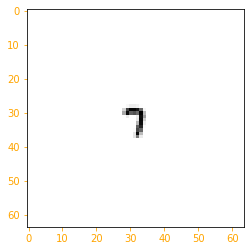

[ 7 10 10 10 10]
Model predicted:::  [ 7 10 10 10 10]


In [ ]:
from random import randint

idx_to_classify = randint(0, len(train_dataset))

plt.imshow(train_dataset[idx_to_classify], cmap=plt.cm.binary)
plt.show()

desired_multilabel_y = train_labels[idx_to_classify]
print(desired_multilabel_y)

# get digits in X, and labels from Y. 
idcs_of_digits = i_to_j_indices[idx_to_classify]

x_to_pred = [X[i] for i in idcs_of_digits]
y_to_pred = [Y[i] for i in idcs_of_digits]

final_output = []

for x in x_to_pred:
  pred = model.predict(x.reshape(1, 18, 18, 1))
  digit = pred.argmax()
  final_output.append(digit)

# should be a better way to do this lol:
while len(final_output) < 5:
  final_output.append(10)

final_output = np.asarray(final_output)
print("Model predicted::: " , final_output)

Now, let's predict a few random unlabelled TEST data to check the model accuracy.

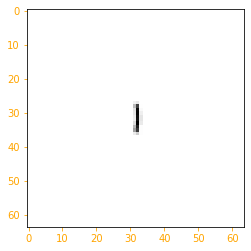

[1, 10, 10, 10, 10]


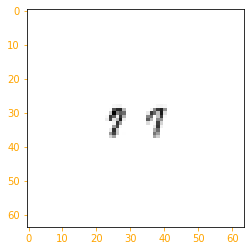

[7, 7, 10, 10, 10]


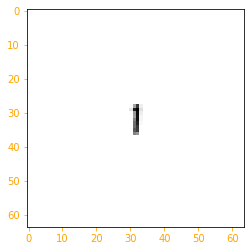

[1, 10, 10, 10, 10]


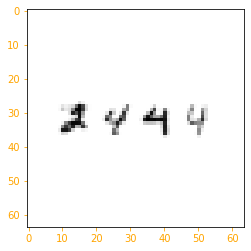

[2, 4, 4, 4, 10]


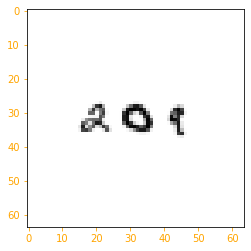

[2, 0, 9, 10, 10]


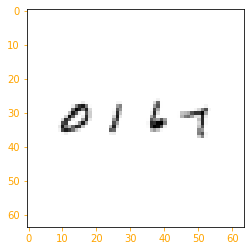

[0, 1, 6, 7, 10]


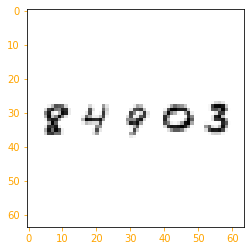

[8, 4, 9, 0, 3]


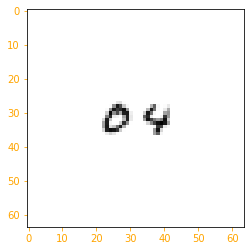

[0, 4, 10, 10, 10]


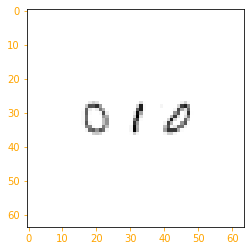

[0, 1, 0, 10, 10]


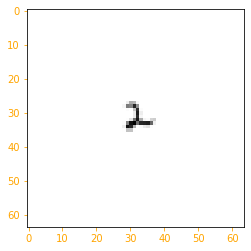

[2, 10, 10, 10, 10]


In [ ]:
inds = np.random.permutation(len(test_dataset))

for idx_to_classify in (inds[:10]):
  plt.imshow(test_dataset[idx_to_classify], cmap=plt.cm.binary)
  plt.show()

  # segments = get_image_segments_test(test_dataset[idx_to_classify], THRESHOLD)
  segments = get_digits_4(test_dataset[idx_to_classify], 18, False)

  final_output = []

  for x in segments:
    pred = model.predict(x.reshape(1, 18, 18, 1))
    digit = pred.argmax()
    final_output.append(digit)

  while len(final_output) < 5:
    final_output.append(10)

  print(final_output)

Finally, let's generate a submission file of the entire test dataset into a csv.

In [ ]:
gen_file = True
import csv
from google.colab import files
from google.colab import output

def gen_kaggle_file():
  rows = []

  rows.append(['Id', 'Label'])

  # classify all test data
  print("Classifying...\t", end='')
  i = 0
  for id, image in enumerate(test_dataset):
    i += 1
    if i%10 == 0:
      output.clear(True, 'status_text')
      with output.use_tags('status_text'):
        print("\r{:.3f}%".format(i/len(test_dataset)*100))

    #segments = get_image_segments_test(image, THRESHOLD)
    segments = get_digits_4(image, IMAGE_SIZE, False)

    final_out = []

    for x in segments:
      pred = model.predict(x.reshape(1,18,18,1))
      digit = pred.argmax()
      final_out.append(digit)

    while len(final_out) < 5:
      final_out.append(10)

    # conv to string
    label = "".join([str(elem) for elem in final_out])
    rows.append([id,label])

  output.clear(True, 'status_text')
  print('Done.')

  print('Generating CSV...\t', end='')
  f = open('submission.csv', 'w')
  fw = csv.writer(f)
  fw.writerows(rows)
  f.close()
  print('Done.')
  files.download("submission.csv")

if gen_file:
  gen_kaggle_file()

Classifying...	Done.
Generating CSV...	Done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>